In [ ]:
# !nvidia-smi -L

In [ ]:
# import os
# from tensorflow.python.profiler import profiler_client

# tpu_profile_service_address = os.environ['COLAB_TPU_ADDR'].replace('8470', '8466')
# print(profiler_client.monitor(tpu_profile_service_address, 100, 2))

In [ ]:
%load_ext autoreload
%autoreload 2

# Data

In [ ]:
from pathlib import Path


DATA_DIR=Path("/content/drive/MyDrive/colab_data/bigscience")
!mkdir -p {DATA_DIR}

!rm -rf sample_data

In [ ]:
TRN_CNT, TRN_OFFSET = 10000, 0
VLD_CNT, VLD_OFFSET = 1000, 1000
ds_key, ds_subkey = "mc4", "en"
ds_name = f"{ds_key}-{ds_subkey}"
trn_jsonl_p = DATA_DIR / f"{ds_name}_trn_{TRN_OFFSET}-{TRN_OFFSET+TRN_CNT}.jsonl"
vld_jsonl_p = DATA_DIR / f"{ds_name}_vld_{VLD_OFFSET}-{VLD_OFFSET+VLD_CNT}.jsonl"

## URL Metadata of mC4 `(trn[:10000], vld[1000:2000])`
Skip this subsection if jsonl files of the same data subsets are prepared before.

In [ ]:
!pip check
!pip install -q datasets[streaming]
!pip check

In [ ]:
from datasets import load_dataset


mc4_en_trn_ds = load_dataset(
    ds_key,
    ds_subkey,
    split="train",
    # data_dir=DATA_DIR,
    streaming=True,
)
mc4_en_vld_ds = load_dataset(
    ds_key,
    ds_subkey,
    split="validation",
    # data_dir=DATA_DIR,
    streaming=True,
)

In [ ]:
!pip check
!pip install -q jsonlines
!pip check

In [ ]:
import jsonlines


def _gen(ds, limit=None, offset=0):
    for i, data in enumerate(ds):
        if i < offset: continue
        if i - offset == limit: break
        yield {
            "text": data['text'],
            "metadata": [{
                "key": "url",
                "type": "global",
                "value": data["url"],
            }],
        }


with jsonlines.open(trn_jsonl_p, mode='w') as writer:
    writer.write_all(l for l in _gen(mc4_en_trn_ds, TRN_CNT, TRN_OFFSET))
with jsonlines.open(vld_jsonl_p, mode='w') as writer:
    writer.write_all(l for l in _gen(mc4_en_vld_ds, VLD_CNT, VLD_OFFSET))

# Trials

## Dependencies

In [ ]:
!pip check
!pip install -qU pip
!pip freeze | grep torch
!pip check

In [ ]:
!pip check
!pip install -q torch==1.8.1 torchvision==0.9.1 torchtext==0.9.1 -f https://download.pytorch.org/whl/cu102/torch_stable.html
!pip freeze | grep torch
!pip check

### TPU
Skip this step if not using TPU.

In [ ]:
!pip check
# From https://github.com/huggingface/notebooks/blob/master/examples/accelerate/simple_nlp_example.ipynb
# Not sure whether we still need not-yet-released accelerate for TPU or not.
# !pip install -q cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
!pip install -q cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8.1-cp37-cp37m-linux_x86_64.whl
# !pip install -q git+https://github.com/huggingface/accelerate
!pip check

### Package

In [ ]:
%cd /content
!rm -rf bigscience-metadata
!git clone -b perf-collator_with_padding_for_tpu https://github.com/tianjianjiang/bigscience-metadata.git

In [ ]:
%cd /content/bigscience-metadata
!pip install -q -e .
!pip check

In [ ]:
!wandb login

## Without URL

In [ ]:
# !TOKENIZERS_PARALLELISM=false \
!accelerate launch --fp16 \
/content/bigscience-metadata/bsmetadata/train.py \
max_train_steps=100 num_eval=1 \
data_config.experiment=without_metadata \
data_config.per_device_eval_batch_size=8 \
data_config.max_seq_len=768 \
data_config.train_file={trn_jsonl_p} \
data_config.validation_file={vld_jsonl_p}

data_config:
  experiment: without_metadata
  per_device_eval_batch_size: 8
  per_device_train_batch_size: 2
  metadata_list: []
  metadata_sep: ' | '
  metadata_key_value_sep: ': '
  metadata_probability: 1.0
  global_metadata_sep: ' |||'
  max_seq_len: 768
  dataset_name: null
  dataset_config_name: null
  train_file: /content/drive/MyDrive/colab_data/bigscience/mc4-en_trn_0-10000.jsonl
  validation_file: /content/drive/MyDrive/colab_data/bigscience/mc4-en_vld_1000-2000.jsonl
  overwrite_cache: false
  cache_dir: null
  preprocessing_num_workers: null
  validation_split_percentage: 5
  block_size: null
  distributed_type: TPU
weight_decay: 0.0
learning_rate: 5.0e-05
gradient_accumulation_steps: 1
num_train_epochs: 1
max_train_steps: 100
lr_scheduler_type: linear
num_warmup_steps: 1000
seed: 42
out_dir: output_dir
num_eval: 1
model_name: gpt2
project_name: metadata_lm

[2021-09-08 22:35:02,024][datasets.builder][WARNING] - Using custom data configuration default-e08b76da1fb65150
[2021

In [ ]:
# !rm -rf outputs

## With URL

In [ ]:
# !TOKENIZERS_PARALLELISM=false \
!accelerate launch --fp16 \
/content/bigscience-metadata/bsmetadata/train.py \
max_train_steps=100 num_eval=1 \
data_config.experiment=with_metadata \
data_config.per_device_eval_batch_size=8 \
data_config.max_seq_len=768 \
data_config.train_file={trn_jsonl_p} \
data_config.validation_file={vld_jsonl_p}

data_config:
  experiment: with_metadata
  per_device_eval_batch_size: 8
  per_device_train_batch_size: 2
  metadata_list: []
  metadata_sep: ' | '
  metadata_key_value_sep: ': '
  metadata_probability: 1.0
  global_metadata_sep: ' |||'
  max_seq_len: 768
  dataset_name: null
  dataset_config_name: null
  train_file: /content/drive/MyDrive/colab_data/bigscience/mc4-en_trn_0-10000.jsonl
  validation_file: /content/drive/MyDrive/colab_data/bigscience/mc4-en_vld_1000-2000.jsonl
  overwrite_cache: false
  cache_dir: null
  preprocessing_num_workers: null
  validation_split_percentage: 5
  block_size: null
  distributed_type: TPU
weight_decay: 0.0
learning_rate: 5.0e-05
gradient_accumulation_steps: 1
num_train_epochs: 1
max_train_steps: 100
lr_scheduler_type: linear
num_warmup_steps: 1000
seed: 42
out_dir: output_dir
num_eval: 1
model_name: gpt2
project_name: metadata_lm

[2021-09-08 22:39:13,291][datasets.builder][WARNING] - Using custom data configuration default-e08b76da1fb65150
[2021-09

In [ ]:
# !rm -rf outputs

## TBA

In [ ]:
!pip install git+https://git@github.com/bigscience-workshop/promptsource.git@main

In [ ]:
# from promptsource.utils import get_dataset
# tydiqa_pri_ds, failed = get_dataset(ds_key, ds_subkey)
# tydiqa_pri_ds, failed

ds_key, ds_subkey = "tydiqa", "primary_task"
tydiqa_pri_trn_ds = load_dataset(
    ds_key,
    ds_subkey,
    split="train",
    data_dir=DATA_DIR,
    streaming=True
)

In [ ]:
from promptsource.templates import TemplateCollection
template_collection = TemplateCollection()

In [ ]:
tydiqa_pri_tmpls = template_collection.get_dataset(ds_key, ds_subkey)

In [ ]:
tydiqa_pri_tmpls.all_template_names

In [ ]:
from promptsource.utils import removeHyphen

In [ ]:
done = False
for data in tydiqa_pri_trn_ds:
    if data["language"] != "english":
        continue
    for tmpl in tydiqa_pri_tmpls.templates.values():
        inst = tmpl.apply(removeHyphen(data))
        if len(inst) == 2:
            data.pop("passage_answer_candidates", None)
            # data.pop("plaintext_start_byte", None)
            display(data)
            prmp, ans = inst
            display(prmp)
            display(ans)
            outcome = {
                "text": prmp,
                "metadata": [{
                    "key": "url",
                    "type": "global",
                    "value": data["document_url"],
                }],
                "answer": ans,
            }
            print(outcome)
            done = True
        if done:
            break
    if done:
        break

# EDA

## Preprocessing for mC4 jsonl

In [ ]:
from urllib.parse import urlsplit


trn_url_parts_map = dict()
with jsonlines.open(trn_jsonl_p) as trn_jsonl:
    for trn_json in trn_jsonl:
        trn_url = next(filter(lambda x: x["key"] == "url", trn_json["metadata"]))['value']
        trn_url_parts = urlsplit(trn_url)
        trn_url_parts_map[trn_url] = trn_url_parts

In [ ]:
from urllib.parse import unquote_plus

import pandas as pd


trn_url_parts_df = pd.DataFrame(
    data=[(
        url,
        parts.netloc,
        sum(1 for _ in filter(None, parts.netloc.split('.'))),
        parts.hostname if parts.hostname else '',
        parts.port if parts.port else '',
        unquote_plus(parts.path),
        sum(1 for _ in filter(None, parts.path.split('/'))),
        unquote_plus(parts.query),
        unquote_plus(parts.fragment)
        ) for url, parts in trn_url_parts_map.items()],
    columns=[
        'url',
        'netloc',
        'netloc_level_cnt',
        'hostname',
        'port',
        'path',
        'path_level_cnt',
        'query',
        'fragment'
    ]
)

## Basic Stats

In [ ]:
trn_url_parts_df.head()

,url,netloc,netloc_level_cnt,hostname,port,path,path_level_cnt,query,fragment
0,http://www.polkaudio.com/forums/showthread.php...,www.polkaudio.com,3,www.polkaudio.com,,/forums/showthread.php,2,58429-Are-my-speakers-magnetically-shielded&go...,
1,http://www.atthecoachhouse.co.uk/events/practi...,www.atthecoachhouse.co.uk,4,www.atthecoachhouse.co.uk,,/events/practical-course-in-the-natural-crafts...,2,,
2,https://www.digitalspy.com/showbiz/a26775099/l...,www.digitalspy.com,3,www.digitalspy.com,,/showbiz/a26775099/louis-tomlinson-zayn-malik-...,3,,
3,http://www.californialandcan.org/Plumas/Farm-R...,www.californialandcan.org,3,www.californialandcan.org,,/Plumas/Farm-Resources/,2,,
4,https://www.seattlepi.com/local/article/Report...,www.seattlepi.com,3,www.seattlepi.com,,/local/article/Report-cites-major-problems-at-...,3,,


In [ ]:
trn_url_parts_df.describe(percentiles=[.25, .5, .75, .95, .975])

,netloc_level_cnt,path_level_cnt
count,10000.000000,10000.000000
mean,2.845700,2.495700
std,0.583374,1.398491
min,2.000000,0.000000
25%,2.000000,1.000000
50%,3.000000,2.000000
75%,3.000000,3.000000
95%,4.000000,5.000000
97.5%,4.000000,6.000000
max,7.000000,14.000000


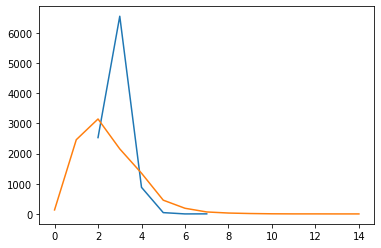

In [ ]:
trn_url_parts_df.netloc_level_cnt.value_counts().sort_index().plot()
trn_url_parts_df.path_level_cnt.value_counts().sort_index().plot()

In [ ]:
trn_url_parts_df[trn_url_parts_df.netloc_level_cnt==7].netloc.tolist()

['bmcinfectdis.biomedcentral.com.preview-live.oscarjournals.springer.com',
 '0-www.loc.gov.oasys.lib.oxy.edu',
 'www.bennettandbelfort.com.php73-36.phx1-1.websitetestlink.com']

In [ ]:
trn_url_parts_df[trn_url_parts_df.path_level_cnt==14].path.tolist()

['/MetroKids/Attractions-and-Events/Attractions-Guide/index.php/alpha/P/category/Theaters/ages/Parents/city/Malvern/county/NJ+-+Burlington+County/']

In [ ]:
trn_url_parts_df = trn_url_parts_df.assign(
    yearlike_path=trn_url_parts_df.path.str.contains(r"20[0-2][0-9]|19\d\d")
)
print(
    f"{len(trn_url_parts_df[trn_url_parts_df.yearlike_path].index)/len(trn_url_parts_df.index):.2%}"
)
trn_url_parts_df.yearlike_path.value_counts().to_dict()

22.52%


{False: 7748, True: 2252}

In [ ]:
trn_url_parts_df[trn_url_parts_df.yearlike_path].path[:10].tolist()

['/news/2005/03/22/on-time-and-on-budget/',
 '/2013/01/19/kitchen-tip-7-how-to-cook-pasta/',
 '/2014/08/18/us-pay-tv-providers-shed-300000-subs-in-q2/',
 '/2011/11/24/reflections-thanksgiving-2011/',
 '/2019/',
 '/oem-parts/2005-suzuki-dr200se-gasket-set/o/m16072sch590528',
 '/Products/Genuine-Joe-Linen-like-Table-Skirts__GJO11915.aspx',
 '/listing/485271256/vintage-90s-1995-58th-annual-postal',
 '/2013/01/08/calendar-cat/',
 '/2012/06/new-model-army-equipment-stolen-can-you-help/']

In [ ]:
import warnings


warnings.simplefilter(action="ignore")  # Just don't want to see `UserWarning` about regex group
trn_url_parts_df = trn_url_parts_df.assign(
    datelike_path=trn_url_parts_df.path.str.contains(
        r"(20[0-2][0-9]|19\d\d)[/\-](0?[1-9]|11|12)[/\-](0?[1-9]|[12]\d|3[01])"
    )
)
print(
    f"{len(trn_url_parts_df[trn_url_parts_df.datelike_path].index)/len(trn_url_parts_df.index):.2%}"
)
trn_url_parts_df.datelike_path.value_counts().to_dict()

7.34%


{False: 9266, True: 734}

In [ ]:
trn_url_parts_df[trn_url_parts_df.datelike_path].path[:10].tolist()

['/news/2005/03/22/on-time-and-on-budget/',
 '/2013/01/19/kitchen-tip-7-how-to-cook-pasta/',
 '/2014/08/18/us-pay-tv-providers-shed-300000-subs-in-q2/',
 '/2011/11/24/reflections-thanksgiving-2011/',
 '/2013/01/08/calendar-cat/',
 '/2016/02/04/the-jesus-revolution/',
 '/2016/03/18/colorado-avalanche-vs-calgary-flames-nhl-betting-hockey-odds-pick-and-prediction/',
 '/news/2013/08/06/communities-should-be-paid-for-wind-and-solar-in-their-neighbourhood/',
 '/2017/11/20/maurizio-cannavacciuolo/',
 '/index.php/2014/02/19/showing-a-little-love/']

## Deprecated Basic EDA of C4 samples.tgz
Old code for raw data of C4 samples.tgz (uncompressed as `dst/en_meta.json`, for example).

### English

In [ ]:
import json
import pandas as pd

from collections import namedtuple
from glob import glob
from urllib.parse import unquote_plus, urlsplit

In [ ]:
%cd /content/drive/MyDrive/colab_data/dst

In [ ]:
with open('en_meta.json') as en_meta_f:
    en_meta_json = json.load(
        en_meta_f,
        object_hook=lambda d: namedtuple(
            'Meta',
            map(lambda k: k.replace('-', '_'), d.keys())
        )(*d.values())
    )

In [ ]:
en_meta_offset_uri_map = {
    row.offset: row.headers.warc_target_uri for row in en_meta_json
}

In [ ]:
en_uri_parts_map = {
    uri: urlsplit(uri) for uri in en_meta_offset_uri_map.values()
}

In [ ]:
i = 0
for (uri, parts) in en_uri_parts_map.items():
    if '%' in parts.path:
        print(f"{i:02d} {uri} -> {unquote_plus(parts.path)} {unquote_plus(parts.query)} {unquote_plus(parts.fragment)}")
        i += 1
    if i > 50:
        break

In [ ]:
en_uri_parts_df = pd.DataFrame(
    data=[(
        uri,
        unquote_plus(parts.path),
        sum(1 for _ in filter(None, parts.path.split('/'))),
        unquote_plus(parts.query),
        unquote_plus(parts.fragment)
        ) for uri, parts in en_uri_parts_map.items()],
    columns=['uri', 'path', 'path_level_cnt', 'query', 'fragment']
)

#### Number of Path Levels

In [ ]:
en_uri_parts_df.describe(percentiles=[.25, .5, .75, .95, .975])

In [ ]:
en_uri_parts_df.path_level_cnt.value_counts().sort_index().plot()

In [ ]:
en_uri_parts_df[en_uri_parts_df.path_level_cnt==33].uri.values

In [ ]:
en_uri_parts_df[en_uri_parts_df.path_level_cnt==5].path.values

#### Year and Date

In [ ]:
en_uri_parts_df = en_uri_parts_df.assign(
    yearlike_path=en_uri_parts_df.path.str.contains(r"20[0-2][0-9]|19\d\d")
)
display(f"{len(en_uri_parts_df[en_uri_parts_df.yearlike_path].index)/len(en_uri_parts_df.index):.2%}")
en_uri_parts_df.yearlike_path.value_counts()

In [ ]:
en_uri_parts_df[en_uri_parts_df.yearlike_path].path.values

In [ ]:
en_uri_parts_df = en_uri_parts_df.assign(
    en_uri_parts_df=en_uri_parts_df.path.str.contains(
        r"(20[0-2][0-9]|19\d\d)[/\-](0?[1-9]|11|12)[/\-](0?[1-9]|[12]\d|3[01])"
    )
)
display(f"{len(en_uri_parts_df[en_uri_parts_df.datelike_path].index)/len(en_uri_parts_df.index):.2%}")
en_uri_parts_df.datelike_path.value_counts()

In [ ]:
en_uri_parts_df[en_uri_parts_df.datelike_path].path.values

### All

In [ ]:
meta_jsons = []
for meta_json_fname in glob('??_meta.json'):
    with open(meta_json_fname) as meta_json_f:
        meta_jsons.extend(
            json.load(
                meta_json_f,
                object_hook=lambda d: namedtuple(
                    'Meta',
                    map(lambda k: k.replace('-', '_'), d.keys())
                )(*d.values())
            )
        )

In [ ]:
meta_offset_uri_map = {
    row.offset: row.headers.warc_target_uri for row in meta_jsons
}

In [ ]:
uri_parts_map = {
    uri: urlsplit(uri) for uri in meta_offset_uri_map.values()
}

In [ ]:
uri_parts_df = pd.DataFrame(
    data=[(
        uri,
        unquote_plus(parts.path),
        sum(1 for _ in filter(None, parts.path.split('/'))),
        unquote_plus(parts.query),
        unquote_plus(parts.fragment)
        ) for uri, parts in uri_parts_map.items()],
    columns=['uri', 'path', 'path_level_cnt', 'query', 'fragment']
)

#### Number of Path Levels

In [ ]:
uri_parts_df.describe(percentiles=[.25, .5, .75, .95, .975])

In [ ]:
uri_parts_df.path_level_cnt.value_counts().sort_index().plot()

In [ ]:
uri_parts_df[uri_parts_df.path_level_cnt==61].uri.values

#### Year and Date

In [ ]:
uri_parts_df = uri_parts_df.assign(
    yearlike_path=df_uri_parts.path.str.contains(r"20[0-2][0-9]|19\d\d")
)
display(f"{len(uri_parts_df[uri_parts_df.yearlike_path].index)/len(uri_parts_df.index):.2%}")
uri_parts_df.yearlike_path.value_counts()

In [ ]:
uri_parts_df = uri_parts_df.assign(
    datelike_path=uri_parts_df.path.str.contains(
        r"(20[0-2][0-9]|19\d\d)[/\-](0?[1-9]|11|12)[/\-](0?[1-9]|[12]\d|3[01])"
    )
)
display(f"{len(uri_parts_df[uri_parts_df.datelike_path].index)/len(uri_parts_df.index):.2%}")
uri_parts_df.datelike_path.value_counts()